<a href="https://colab.research.google.com/github/BaseKan/aiday_training_resources/blob/main/TF_basics/Tensorflow_training_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Model, Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns

In [50]:
# Data downloaden
!curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id=14P4Pv7Lq-pvYTjTRKld_ffrvFk6C7ntv' | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt    
!curl -L -b cookies.txt -o 'telecom_churn.csv' 'https://docs.google.com/uc?export=download&id=14P4Pv7Lq-pvYTjTRKld_ffrvFk6C7ntv&confirm='$(<confirm.txt)
!rm -f confirm.txt cookies.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   388    0   388    0     0    262      0 --:--:--  0:00:01 --:--:--   262
100  631k  100  631k    0     0   329k      0  0:00:01  0:00:01 --:--:--  154M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0    260      0 --:--:--  0:00:01 --:--:--   260
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  631k  100  631k    0     0   276k      0  0:00:02  0:00:02 --:--:--  276k


In [51]:
import io
df = pd.read_csv('telecom_churn.csv')

In [52]:
df.head()

,Unnamed: 0,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,Male,0,Yes,Yes,72,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),24.10,1734.65,No
1,1,Female,0,No,No,44,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,No,Month-to-month,Yes,Credit card (automatic),88.15,3973.20,No
2,2,Female,1,Yes,No,38,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),74.95,2869.85,Yes
3,3,Male,0,No,No,4,Yes,No,DSL,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,55.90,238.50,No
4,4,Male,0,No,No,2,Yes,No,DSL,Yes,No,Yes,No,No,No,Month-to-month,No,Electronic check,53.45,119.50,No


# Baseline model

In [53]:
from sklearn.pipeline import make_pipeline, make_union
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [54]:
from sklearn.base import TransformerMixin, BaseEstimator

class DTypeSelector(BaseEstimator, TransformerMixin):

    def __init__(self, dtypes):
        self.dtypes = dtypes


    def fit(self, X, y):
        return self


    def transform(self, X):
        return X.select_dtypes(self.dtypes)

In [55]:
X = df.drop(columns='Churn')
y = df['Churn']

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [57]:
def create_model(optimizer='adam'):
    model = Sequential()
    
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',optimizer=optimizer, metrics=['accuracy', keras.metrics.Precision(name='precision'),keras.metrics.Recall(name='recall')])
    
    return model

In [58]:
pipeline = make_pipeline(
    make_union(
        make_pipeline(
        DTypeSelector('number'),
        SimpleImputer(),
        StandardScaler()
    ),
        make_pipeline(
        DTypeSelector('object'),
        SimpleImputer(strategy='most_frequent'),
        OneHotEncoder()
    )
    ),
    KerasClassifier(build_fn=create_model,verbose=1, epochs=100, batch_size=32)
)

In [59]:
pipeline

Pipeline(memory=None,
         steps=[('featureunion',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('pipeline-1',
                                                 Pipeline(memory=None,
                                                          steps=[('dtypeselector',
                                                                  DTypeSelector(dtypes='number')),
                                                                 ('simpleimputer',
                                                                  SimpleImputer(add_indicator=False,
                                                                                copy=True,
                                                                                fill_value=None,
                                                                                missing_values=nan,
                                                                                strategy='mean',
                 

In [ ]:
pipeline.fit(X_train, y_train)

In [66]:
pipeline[1].model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 100)               4700      
_________________________________________________________________
dense_25 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_26 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_27 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_28 (Dense)             (None, 100)               10100     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 101       
Total params: 45,201
Trainable params: 45,201
Non-trainable params: 0
__________________________________________________

In [67]:
df_loss = pd.DataFrame(pipeline[1].model.history.history)

In [68]:
df_loss

,loss,accuracy,precision,recall
0,0.261303,0.919838,0.000000,0.000000
1,0.222994,0.920150,0.000000,0.000000
2,0.217247,0.920150,0.000000,0.000000
3,0.211869,0.920150,0.000000,0.000000
4,0.205900,0.919838,0.333333,0.003906
...,...,...,...,...
95,0.023419,0.988771,0.947154,0.910156
96,0.023317,0.989395,0.982609,0.882812
97,0.022247,0.990954,0.982979,0.902344
98,0.017634,0.990019,0.970588,0.902344


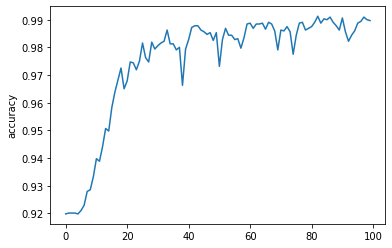

In [74]:
sns.lineplot(y=df_loss['accuracy'], x=df_loss.index)

In [75]:
from sklearn.metrics import classification_report, confusion_matrix

In [77]:
y_hat_test = pipeline.predict(X_test)
y_hat_train = pipeline.predict(X_train)

 54/101 [===============>..............] - ETA: 0s

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses

101/101 [==============================] - 0s 981us/step


In [78]:
print(classification_report(y_train, y_hat_train))

              precision    recall  f1-score   support

          No       0.99      1.00      0.99      2950
         Yes       0.98      0.90      0.94       256

    accuracy                           0.99      3206
   macro avg       0.98      0.95      0.97      3206
weighted avg       0.99      0.99      0.99      3206



In [79]:
print(classification_report(y_test, y_hat_test))

              precision    recall  f1-score   support

          No       0.94      0.93      0.94      1449
         Yes       0.29      0.29      0.29       131

    accuracy                           0.88      1580
   macro avg       0.61      0.61      0.61      1580
weighted avg       0.88      0.88      0.88      1580

